In [2]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
pipe = pipeline(model="facebook/bart-large-mnli")
outputs = pipe('пожелать',
    candidate_labels=['Подарок', 'Пожелание'],
)
outputs

Device set to use mps:0


In [ ]:
outputs['labels'][0]

'Пожелание'

In [ ]:
pipe('подготовить сюрприз родителям',
    candidate_labels=['подарок', 'желание'],
)

{'sequence': 'подготовить сюрприз родителям',
 'labels': ['подарок', 'желание'],
 'scores': [0.663544237613678, 0.3364557921886444]}

In [ ]:
model_checkpoint = 'cointegrated/rubert-base-cased-nli-threeway'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)


def predict_zero_shot(text, label_texts, model, tokenizer, label='entailment', normalize=True):
    tokens = tokenizer([text] * len(label_texts), label_texts, truncation=True, return_tensors='pt', padding=True)
    with torch.inference_mode():
        result = torch.softmax(model(**tokens.to(model.device)).logits, -1)
    proba = result[:, model.config.label2id[label]].cpu().numpy()
    if normalize:
        proba /= sum(proba)
    return proba

classes = ['подарок', 'желание']
predict_zero_shot('подготовить сюрприз родителям', classes, model, tokenizer)

array([0.37635893, 0.6236411 ], dtype=float32)

In [12]:
from diffusers import DiffusionPipeline
import torch

# load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
n_steps = 10
high_noise_frac = 0.8

prompt = "A majestic lion jumping from a big stone at night"

# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
    width=160,
    height=160,
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
    width=160,
    height=160,
).images[0]


  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", 
                                         torch_dtype=torch.float16, 
                                         use_safetensors=True, 
                                         variant="fp16"
                                        )
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

prompt = "An astronaut riding a green horse"

images = pipe(prompt=prompt, num_inference_steps=5, height=160, width=160).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from diffusers import StableDiffusionImageVariationPipeline, StableDiffusionPipeline
import torch 

sd_pipeline = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
sd_pipeline = sd_pipeline.to("cuda")



Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   5%|5         | 178M/3.44G [00:00<?, ?B/s]

model.safetensors:  18%|#8        | 220M/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:  91%|######### | 304M/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
from transformers import pipeline

pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-ru-en")
translate = pipe("A red box with a New Year's gift under a beautiful green Christmas tree")
translate

Device set to use cuda:0


[{'translation_text': "A red box with a New Year's gift under a beautiful green Christmas tree"}]

"A red box with a New Year's gift under a beautiful green Christmas tree"

In [8]:
out = sd_pipeline(translate[0]['translation_text'], num_inference_steps=50)

NameError: name 'sd_pipeline' is not defined

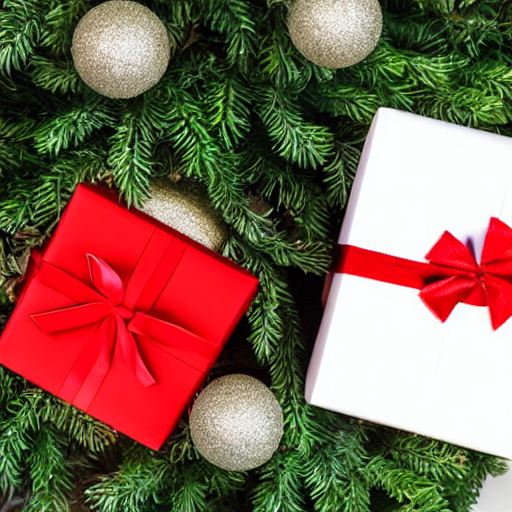

In [10]:
out["images"][0]